In [1]:
import os
import time
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import ConvRNN2D, SpatialDropout1D, Reshape, MaxPool2D, Concatenate, Flatten

from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.engine.topology import Layer
import matplotlib.pyplot as plt
%matplotlib inline

#Source: https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

gpu_options = K.tf.GPUOptions(per_process_gpu_memory_fraction = 1)
config = K.tf.ConfigProto(gpu_options = gpu_options, allow_soft_placement = True)
K.set_session(K.tf.Session(config = config))

In [3]:
base_path = "/home/nbatanay/.kaggle/quora-insincere-questions-classification/"
train_df = pd.read_csv(base_path+"train.csv")
test_df = pd.read_csv(base_path+"test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [4]:
%%time
## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

CPU times: user 1min 1s, sys: 692 ms, total: 1min 2s
Wall time: 59.3 s


In [5]:
print("Train: ", train_X.shape, train_y.shape)
print("Validation: ", val_X.shape, val_y.shape)
print("Test :", test_X.shape)

Train:  (1175509, 100) (1175509,)
Validation:  (130613, 100) (130613,)
Test : (56370, 100)


### Without Embeddings

In [30]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = Conv1D(64, 3)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 100, 256)          330240    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 64)            49216     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
__________

In [31]:
%%time
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 182s 155us/step - loss: 0.1209 - acc: 0.9522 - val_loss: 0.1072 - val_acc: 0.9564
Epoch 2/3
1175509/1175509 [==============================] - 179s 152us/step - loss: 0.0985 - acc: 0.9604 - val_loss: 0.1077 - val_acc: 0.9573
Epoch 3/3
1175509/1175509 [==============================] - 179s 152us/step - loss: 0.0837 - acc: 0.9665 - val_loss: 0.1119 - val_acc: 0.9564
CPU times: user 6min 12s, sys: 1min 14s, total: 7min 26s
Wall time: 9min


130613/130613 [==============================] - 6s 45us/step


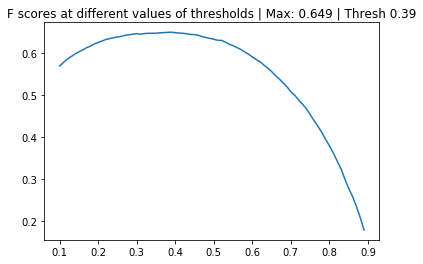

In [32]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Glove Embedding

In [33]:
EMBEDDING_FILE = '/home/nbatanay/.kaggle/quora-insincere-questions-classification/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total para

In [34]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 124s 106us/step - loss: 0.1133 - acc: 0.9558 - val_loss: 0.1009 - val_acc: 0.9592
Epoch 2/2
1175509/1175509 [==============================] - 120s 102us/step - loss: 0.0931 - acc: 0.9628 - val_loss: 0.1011 - val_acc: 0.9602


130613/130613 [==============================] - 4s 31us/step


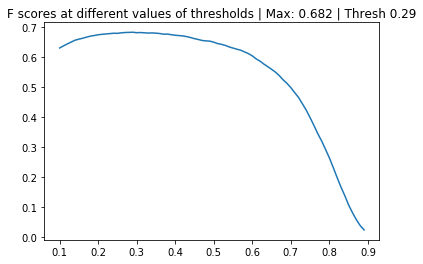

In [35]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Wiki-News Embedding

In [36]:
EMBEDDING_FILE = '/home/nbatanay/.kaggle/quora-insincere-questions-classification/wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total para

In [37]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 125s 107us/step - loss: 0.1205 - acc: 0.9550 - val_loss: 0.1031 - val_acc: 0.9584
Epoch 2/2
1175509/1175509 [==============================] - 121s 103us/step - loss: 0.0960 - acc: 0.9624 - val_loss: 0.1027 - val_acc: 0.9589


130613/130613 [==============================] - 4s 33us/step


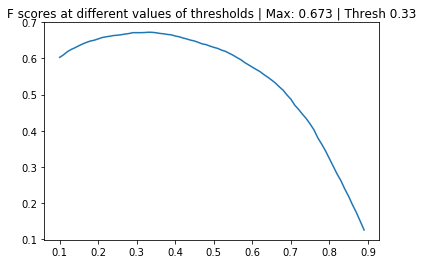

In [38]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Paragram Embedding

In [39]:
EMBEDDING_FILE = '/home/nbatanay/.kaggle/quora-insincere-questions-classification/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100, 256)          330240    
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total para

In [40]:
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 174s 148us/step - loss: 0.1139 - acc: 0.9553 - val_loss: 0.1047 - val_acc: 0.9579
Epoch 2/3
1175509/1175509 [==============================] - 170s 145us/step - loss: 0.0945 - acc: 0.9623 - val_loss: 0.0998 - val_acc: 0.9596
Epoch 3/3
1175509/1175509 [==============================] - 170s 145us/step - loss: 0.0815 - acc: 0.9675 - val_loss: 0.1033 - val_acc: 0.9593


130613/130613 [==============================] - 6s 42us/step


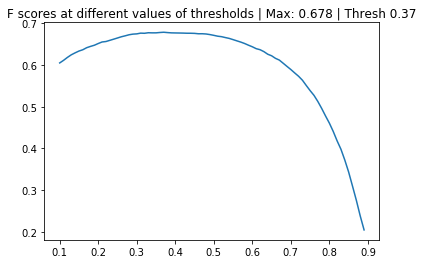

In [41]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Concatenate all the embeddings

In [7]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

base_path = "/home/nbatanay/.kaggle/quora-insincere-questions-classification/"
glove_file = "glove.840B.300d/glove.840B.300d.txt"
glove_index = dict(get_coefs(*o.split(" ")) for o in open(base_path+glove_file))

wiki_file = "wiki-news-300d-1M/wiki-news-300d-1M.vec"
wiki_index = dict(get_coefs(*o.split(" ")) for o in open(base_path+wiki_file) if len(o)>100)

paragram_file = "paragram_300_sl999/paragram_300_sl999.txt"
paragram_index = dict(get_coefs(*o.split(" ")) for o in open(base_path+paragram_file,
                                                             encoding="utf8", 
                                                             errors='ignore') if len(o)>100)

In [8]:
embed_index = {"glove": glove_index,
               "wiki": wiki_index,
               "paragram": paragram_index}

embedding_matrices = {}
for emb in embed_index.keys():
    all_embs = np.stack(embed_index[emb].values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embed_index[emb].get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    embedding_matrices[emb] = embedding_matrix

In [44]:
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(merged)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 100, 300)     15000000    input_12[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 100, 300)     15000000    input_12[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 100, 300)     15000000    input_12[0][0]                   
__________________________________________________________________________________________________
concatenat

In [45]:
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 347s 295us/step - loss: 0.1106 - acc: 0.9561 - val_loss: 0.1002 - val_acc: 0.9602
Epoch 2/3
1175509/1175509 [==============================] - 344s 292us/step - loss: 0.0913 - acc: 0.9632 - val_loss: 0.1008 - val_acc: 0.9604
Epoch 3/3
1175509/1175509 [==============================] - 344s 292us/step - loss: 0.0744 - acc: 0.9702 - val_loss: 0.1068 - val_acc: 0.9583


130613/130613 [==============================] - 10s 77us/step


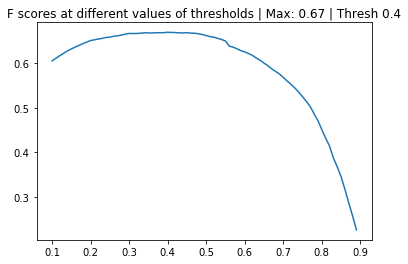

In [46]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

---

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 100, 300)     15000000    input_13[0][0]                   
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 100, 300)     15000000    input_13[0][0]                   
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 100, 300)     15000000    input_13[0][0]                   
__________________________________________________________________________________________________
bidirectio

/home/nbatanay/.conda/envs/nlp_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 13min 45s, sys: 1min 49s, total: 15min 34s
Wall time: 17min 41s


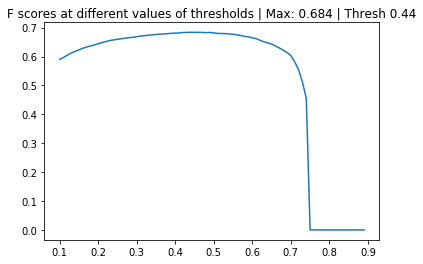

In [47]:
%%time
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_glove = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_glove)
inp_glove = GlobalMaxPool1D()(inp_glove)

inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_wiki = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_wiki)
inp_wiki = GlobalMaxPool1D()(inp_wiki)

inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
inp_paragram = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_paragram)
inp_paragram = GlobalMaxPool1D()(inp_paragram)

merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Dense(16, activation="relu")(merged)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

#model performance 
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     15000000    input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     15000000    input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     15000000    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectio

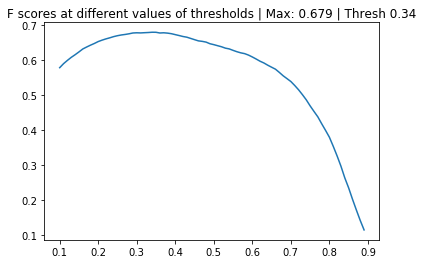

In [9]:
%%time
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_glove = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_glove)
inp_glove = GlobalMaxPool1D()(inp_glove)

inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_wiki = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_wiki)
inp_wiki = GlobalMaxPool1D()(inp_wiki)

inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
inp_paragram = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_paragram)
inp_paragram = GlobalMaxPool1D()(inp_paragram)

merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Dense(32, activation="relu")(merged)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train
model.fit(train_X, train_y, batch_size=256, epochs=2, validation_data=(val_X, val_y))

#model performance 
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### with Attention Layer

In [12]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     15000000    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 300)     15000000    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 100, 300)     15000000    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectio

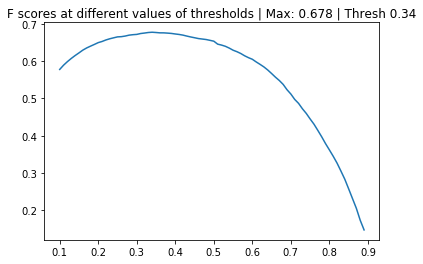

In [13]:
%%time
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_glove = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_glove)
inp_glove = Attention(maxlen)(inp_glove)
#inp_glove = GlobalMaxPool1D()(inp_glove)

inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_wiki = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_wiki)
inp_wiki = Attention(maxlen)(inp_wiki)
#inp_wiki = GlobalMaxPool1D()(inp_wiki)

inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
inp_paragram = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_paragram)
inp_paragram = Attention(maxlen)(inp_paragram)
#inp_paragram = GlobalMaxPool1D()(inp_paragram)

merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Dense(32, activation="relu")(merged)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train
model.fit(train_X, train_y, batch_size=256, epochs=2, validation_data=(val_X, val_y))

#model performance 
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

In [14]:
from keras.layers import CuDNNLSTM

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 100, 300)     15000000    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 100, 300)     15000000    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 100, 300)     15000000    input_5[0][0]                    
__________________________________________________________________________________________________
bidirectio

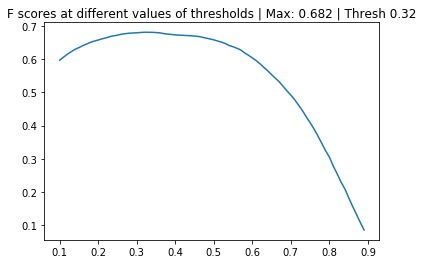

In [16]:
%%time
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_glove = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp_glove)
inp_glove = Attention(maxlen)(inp_glove)
#inp_glove = GlobalMaxPool1D()(inp_glove)

inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_wiki = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_wiki)
inp_wiki = Attention(maxlen)(inp_wiki)
#inp_wiki = GlobalMaxPool1D()(inp_wiki)

inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
inp_paragram = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_paragram)
inp_paragram = Attention(maxlen)(inp_paragram)
#inp_paragram = GlobalMaxPool1D()(inp_paragram)

merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Dense(32, activation="relu")(merged)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train
model.fit(train_X, train_y, batch_size=256, epochs=2, validation_data=(val_X, val_y))

#model performance 
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

In [18]:
from keras.layers import Conv2D

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 100, 300)     15000000    input_14[0][0]                   
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 100, 300)     15000000    input_14[0][0]                   
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 100, 300)     15000000    input_14[0][0]                   
__________________________________________________________________________________________________
spatial_dr

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 608s 517us/step - loss: 0.1157 - acc: 0.9547 - val_loss: 0.1029 - val_acc: 0.9584
Epoch 2/2
130613/130613 [==============================] - 21s 162us/step
CPU times: user 12min 8s, sys: 3min 14s, total: 15min 23s
Wall time: 21min 27s


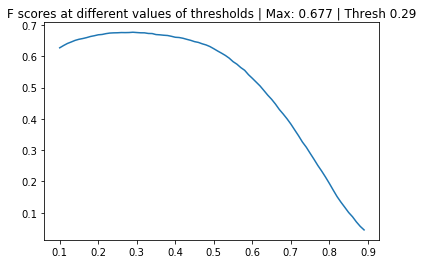

In [28]:
%%time

filter_sizes = [1, 2, 3, 5]
num_filt = 36

inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
#inp_glove = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp_glove)
#inp_glove = Attention(maxlen)(inp_glove)


inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
#inp_wiki = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_wiki)
#inp_wiki = Attention(maxlen)(inp_wiki)


inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
#inp_paragram = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_paragram)
#inp_paragram = Attention(maxlen)(inp_paragram)

embeddings = [inp_glove, 
              inp_wiki,
              inp_paragram]

embed_maxpools = []
for embed in embeddings:
    embed = SpatialDropout1D(0.1)(embed)
    embed = Reshape((maxlen, embed_size, 1))(embed)
    
    maxpools = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filt, kernel_size=(filter_sizes[i], embed_size),
                  kernel_initializer="he_normal", activation="elu")(embed)
        maxpools.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))
    merged = Concatenate(axis=1)(maxpools)
    merged = Flatten()(merged)
    merged = Dropout(0.2)(merged)
    
    embed_maxpools.append(merged)

embed_maxpools = Concatenate(axis=1)(embed_maxpools)
#"""   
x = Dense(32, activation="relu")(embed_maxpools)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train
model.fit(train_X, train_y, batch_size=256, epochs=2, validation_data=(val_X, val_y))

#model performance 
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))
#"""